In [1]:
# Check GPU availability
import tensorflow as tf
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# Cell 0: Imports and Setup
import keras_tuner as kt
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import KFold, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from xgboost import XGBClassifier

# Configure logging and warnings
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

%matplotlib inline

### Custom Transformers for Unified Feature Engineering and Outlier Treatment
We define two custom transformers:
- **UnifiedFeatureEngineer:** A scikit‑learn transformer that builds a unified feature set. It creates date‑based, periodic, interaction, lag (if training), polynomial (degree 2 on candidate columns), and rolling window features.
- **OutlierTreatmentTransformer:** Clips numeric features based on a (tunable) IQR multiplier.

In [3]:
# Custom Transformers
from sklearn.base import BaseEstimator, TransformerMixin

class UnifiedFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Generates an extended feature set.
    
    - Builds a date from the 'day' column (assumes day 1 = 2024-01-01).
    - Extracts date-based features (month, day_of_year, week_of_year, quarter, day_of_week, is_weekend).
    - Creates periodic features (sine and cosine transforms for day and month).
    - Computes interaction/ratio features (e.g. temp_range, humidity_cloud_ratio, etc.).
    - For training (is_train=True), computes lag features from the target.
    - Generates degree-2 polynomial features on candidate columns if provided.
    - Computes rolling-window statistics (mean and standard deviation) for all numeric features.
    - Removes duplicate columns (to avoid length mismatches).
    """
    def __init__(self, is_train=False, target_col='rainfall', poly_cols=None, roll_windows=[7,14]):
        self.is_train = is_train
        self.target_col = target_col
        self.poly_cols = poly_cols
        self.roll_windows = roll_windows
        
    def fit(self, X, y=None):
        # Check if the required column exists.
        missing = set(['day']) - set(X.columns)
        if missing:
            logger.warning(f"Missing required columns for feature engineering: {missing}")
        return self

    def transform(self, X, y=None):
        df = X.copy()
        
        # --- Date-based features ---
        if 'day' in df.columns:
            base_date = pd.to_datetime('2024-01-01')
            df['date'] = base_date + pd.to_timedelta(df['day'] - 1, unit='D')
            df['month'] = df['date'].dt.month
            df['day_of_year'] = df['date'].dt.dayofyear
            df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
            df['quarter'] = df['date'].dt.quarter
            df['day_of_week'] = df['date'].dt.weekday
            df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
            df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
            df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
            df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
            df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        else:
            logger.warning("Column 'day' not found; skipping date-based features.")
        
        # --- Additional features ---
        # Lag features for pressure and humidity.
        for lag in [1, 3, 7]:
            if 'pressure' in df.columns:
                df[f'Pressure_lag{lag}'] = df['pressure'].shift(lag)
            if 'humidity' in df.columns:
                df[f'Humidity_lag{lag}'] = df['humidity'].shift(lag)
        # Amount of change.
        if 'pressure' in df.columns:
            df['Pressure_change_1d'] = df['pressure'] - df['pressure'].shift(1)
        if 'humidity' in df.columns:
            df['Humidity_change_1d'] = df['humidity'] - df['humidity'].shift(1)
        # Temperature features.
        if all(col in df.columns for col in ['maxtemp', 'mintemp']):
            df['temp_range'] = df['maxtemp'] - df['mintemp']
            df['avg_temp'] = (df['maxtemp'] + df['mintemp']) / 2
        if all(col in df.columns for col in ['temparature', 'dewpoint']):
            df['temp_dew_diff'] = df['temparature'] - df['dewpoint']
        # Sunshine and cloud.
        if all(col in df.columns for col in ['sunshine', 'cloud']):
            df['Sunshine_per_hour'] = df['sunshine'] / 24
            df['Cloud_per_hour'] = df['cloud'] / 24
            if 'humidity' in df.columns:
                df['Cloud_Humidity_ratio'] = df['cloud'] / (df['humidity'] + 1e-5)
            df['Cloud_Sunshine_ratio'] = df['cloud'] / (df['sunshine'] + 1e-5)
        # Wind features.
        if all(col in df.columns for col in ['windspeed', 'winddirection']):
            df['Wind_x'] = df['windspeed'] * np.cos(np.radians(df['winddirection']))
            df['Wind_y'] = df['windspeed'] * np.sin(np.radians(df['winddirection']))
        # Other interactions.
        for col in ['humidity', 'cloud', 'pressure', 'sunshine']:
            if col not in df.columns:
                df[col] = np.nan
        df['humidity_cloud_interaction'] = df['humidity'] * df['cloud']
        df['humidity_sunshine_interaction'] = df['humidity'] * df['sunshine']
        df['Pressure_Humidity_Interaction'] = df['pressure'] * df['humidity']
        df['cloud_wind_interaction'] = df['cloud'] * df['windspeed']
        df['relative_dryness'] = 100 - df['humidity']
        df['sunshine_percentage'] = df['sunshine'] / (df['sunshine'] + df['cloud'] + 1e-5)
        df['cloud_percentage'] = df['cloud'] / (df['sunshine'] + df['cloud'] + 1e-5)
        df['weather_index'] = (0.4 * df['humidity']) + (0.3 * df['cloud']) - (0.3 * df['sunshine'])
        if 'maxtemp' in df.columns:
            df['Temp_Ratio'] = df['temparature'] / df['maxtemp'].max()
        df['Try'] = df['humidity'] + df['cloud'] + df['dewpoint']
        df['Try_2'] = (df['cloud'] - df['sunshine']) + df['temparature']
        
        # Wet-bulb temperature and vapor pressure deficit.
        if all(col in df.columns for col in ['temparature', 'humidity', 'dewpoint']):
            def calc_wet_bulb(T, RH):
                return T * np.arctan(0.151977 * np.sqrt(RH + 8.313659)) + \
                       np.arctan(T + RH) - np.arctan(RH - 1.676331) + \
                       0.00391838 * (RH ** (3/2)) * np.arctan(0.023101 * RH) - 4.686035
            df['wet_bulb_temp'] = calc_wet_bulb(df['temparature'], df['humidity'])
            df['e_s_temp'] = 6.11 * np.exp((17.27 * df['temparature']) / (df['temparature'] + 237.3))
            df['e_s_dewpoint'] = 6.11 * np.exp((17.27 * df['dewpoint']) / (df['dewpoint'] + 237.3))
            df['vapor_pressure_deficit'] = df['e_s_temp'] - df['e_s_dewpoint']
        
        # --- Lag features for target (only for training) ---
        if self.is_train:
            if self.target_col in df.columns:
                df[self.target_col] = df[self.target_col].astype(float)
            else:
                logger.warning(f"Target column '{self.target_col}' not found!")
            df = df.sort_values('date').reset_index(drop=True)
            df['rain_prev'] = df[self.target_col].shift(1).fillna(0)
            df['rain_next'] = df[self.target_col].shift(-1).fillna(0)
            df['gap_before'] = df.groupby((df['rain_prev'] != df[self.target_col]).cumsum()).cumcount()
            df['gap_after'] = df[::-1].groupby((df['rain_next'] != df[self.target_col]).cumsum()).cumcount()
            df.drop(['rain_prev', 'rain_next'], axis=1, inplace=True)
        else:
            df['gap_before'] = 0
            df['gap_after'] = 0

        # Drop temporary date column.
        df.drop(['date'], axis=1, inplace=True, errors='ignore')
        
        # --- Polynomial Features ---
        if self.poly_cols is not None:
            df_imputed = df[self.poly_cols].fillna(df[self.poly_cols].median())
            poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
            poly_features = poly.fit_transform(df_imputed)
            poly_feature_names = poly.get_feature_names_out(self.poly_cols)
            poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
            df = pd.concat([df, poly_df], axis=1)
        
        # Remove duplicate columns (if any) to ensure unique feature names.
        df = df.loc[:, ~df.columns.duplicated()]
        
        # --- Rolling Window Features ---
        df_roll = pd.DataFrame(index=df.index)
        num_cols = df.select_dtypes(include=[np.number]).columns
        for col in num_cols:
            series_col = df[col]
            for window in self.roll_windows:
                roll_mean = series_col.rolling(window=window, min_periods=1).mean().values.reshape(-1)
                roll_std = series_col.rolling(window=window, min_periods=1).std().fillna(0).values.reshape(-1)
                df_roll[f'{col}_roll_mean_{window}'] = roll_mean
                df_roll[f'{col}_roll_std_{window}'] = roll_std
        df = pd.concat([df, df_roll], axis=1)
        return df

class OutlierTreatmentTransformer(BaseEstimator, TransformerMixin):
    """
    Clips numeric features using IQR-based thresholds.
    """
    def __init__(self, multiplier=1.5):
        self.multiplier = multiplier

    def fit(self, X, y=None):
        self.stats_ = {}
        for col in X.select_dtypes(include=[np.number]).columns:
            series = X[col]
            Q1 = np.nanquantile(series, 0.25)
            Q3 = np.nanquantile(series, 0.75)
            IQR = Q3 - Q1
            self.stats_[col] = (Q1 - self.multiplier * IQR, Q3 + self.multiplier * IQR)
        return self

    def transform(self, X):
        X_out = X.copy()
        for col, (lower, upper) in self.stats_.items():
            X_out[col] = np.clip(X_out[col], lower, upper)
        return X_out

### Load and Optimize Data
Load the training and test datasets, apply memory optimization, and split into features and target.

In [4]:
# Load and Optimize Data
def reduce_memory_usage(df):
    """Downcasts numeric columns to reduce memory usage."""
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

# Update file paths as needed.
train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

# Split training data into features and target.
X = train.drop(['id', 'rainfall'], axis=1)
y = train['rainfall']

# Save test IDs and features.
test_ids = test['id']
X_test = test.drop(['id'], axis=1)

logger.info(f"Train shape: {X.shape}, Test shape: {X_test.shape}")
print(f"Train shape: {X.shape}, Test shape: {X_test.shape}")

Train shape: (2190, 11), Test shape: (730, 11)


### Extended Feature Engineering and Alignment
Apply the unified feature engineering transformer to both training and test data, then align columns.

In [5]:
# Extended Feature Engineering and Alignment
# Define candidate columns for polynomial features.
candidate_poly_cols = ['maxtemp', 'mintemp', 'temparature', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'pressure', 'winddirection', 'windspeed']

# For training: combine X and y to compute lag features.
engineer_train = UnifiedFeatureEngineer(is_train=True, target_col='rainfall', poly_cols=candidate_poly_cols, roll_windows=[7,14])
train_ext = engineer_train.fit_transform(pd.concat([X, y], axis=1))
y_ext = train_ext.pop('rainfall')  # Extract target.

# For test data: compute features without lag.
engineer_test = UnifiedFeatureEngineer(is_train=False, poly_cols=candidate_poly_cols, roll_windows=[7,14])
test_ext = engineer_test.fit_transform(X_test)

# Align columns (fill missing with 0).
all_cols = train_ext.columns.union(test_ext.columns)
X_ext_full = train_ext.reindex(columns=all_cols, fill_value=0)
X_test_ext_full = test_ext.reindex(columns=all_cols, fill_value=0)

logger.info(f"Extended Train Shape: {X_ext_full.shape}")
logger.info(f"Extended Test Shape: {X_test_ext_full.shape}")
print(f"Extended Train Shape: {X_ext_full.shape} \n Extended Test Shape: {X_test_ext_full.shape}")

Extended Train Shape: (2190, 554) 
 Extended Test Shape: (730, 554)


### Outlier Treatment
Apply the outlier treatment transformer to the extended features.

In [6]:
# Outlier Treatment
outlier_transformer = OutlierTreatmentTransformer(multiplier=1.5)
X_ext_iqr = outlier_transformer.fit_transform(X_ext_full)
X_test_ext_iqr = outlier_transformer.transform(X_test_ext_full)

### Pipeline Function for Model Training and Submission with Feature Selection
This function builds a pipeline that includes imputation, scaling, feature selection (SelectFromModel), and the classifier. It then performs hyperparameter tuning and saves a submission CSV.

In [7]:
# Pipeline Function
def train_and_submit(X_train, y_train, X_pred, model, param_dist, model_name):
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('selector', SelectFromModel(ExtraTreesClassifier(n_estimators=100, random_state=42), threshold='median')),
        ('clf', model)
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    search = RandomizedSearchCV(pipeline, param_dist, n_iter=50, scoring='roc_auc', cv=cv, random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    
    best_score = search.best_score_
    logger.info(f"Best CV ROC AUC for {model_name}: {best_score:.4f}")
    logger.info(f"Best Params for {model_name}: {search.best_params_}")
    
    # Log the features selected by the selector.
    selector = search.best_estimator_.named_steps['selector']
    selected_mask = selector.get_support()
    selected_features = X_train.columns[selected_mask]
    logger.info(f"Selected features for {model_name} ({len(selected_features)} features): {selected_features.tolist()}")
    
    # Align test set columns.
    X_pred_aligned = X_pred.reindex(columns=X_train.columns, fill_value=0)
    
    try:
        preds = search.predict_proba(X_pred_aligned.values)[:, 1]
    except Exception as e:
        logger.error(f"Error in predict_proba for {model_name}: {e}")
        preds = np.full(len(X_pred_aligned), 0.5)
    
    submission = pd.DataFrame({'id': test_ids, 'rainfall': preds})
    submission_filename = f"{model_name}_submission.csv"
    submission.to_csv(submission_filename, index=False)
    logger.info(f"Submission for {model_name} saved as: {submission_filename}")
    return best_score

## Train Multiple Models (Excluding DNN)

We define parameter grids for each model and then loop over each model to perform hyperparameter tuning and save a submission file.

In [8]:
# Train Classical Models
param_grids = {
    'LogisticRegression': {
        'clf__C': np.logspace(-3, 2, 10),
        'clf__solver': ['lbfgs', 'liblinear']
    },
    'DecisionTree': {
        'clf__max_depth': [3, 5, 7, None],
        'clf__min_samples_split': [2, 5, 10]
    },
    'ExtraTrees': {
        'clf__n_estimators': [50, 100, 150],
        'clf__max_depth': [5, 7, None]
    },
    'RandomForest': {
        'clf__n_estimators': [50, 100, 150],
        'clf__max_depth': [5, 7, None]
    },
    'XGBoost': {
        'clf__n_estimators': [50, 100, 150],
        'clf__max_depth': [3, 5, 7]
    },
    'CatBoost': {
        'clf__iterations': [100, 200],
        'clf__depth': [4, 6]
    },
    'LGBM': {
        'clf__num_leaves': [31, 50],
        'clf__n_estimators': [50, 100, 150]
    },
    'KNN': {
        'clf__n_neighbors': [3, 5, 7],
        'clf__weights': ['uniform', 'distance']
    },
    'SVC': {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    }
}

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'LGBM': LGBMClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=42)
}

model_results = {}
for model_name, model in models.items():
    logger.info(f"\nTraining {model_name} on Extended IQR-treated & Standard Scaled features:")
    auc = train_and_submit(X_ext_iqr, y_ext, X_test_ext_iqr, model, param_grids[model_name], model_name)
    model_results[model_name] = auc

[LightGBM] [Info] Number of positive: 1650, number of negative: 540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62641
[LightGBM] [Info] Number of data points in the train set: 2190, number of used features: 277
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.753425 -> initscore=1.116961
[LightGBM] [Info] Start training from score 1.116961


### Neural Network Model with Extensive Hyperparameter Tuning
Here we build a neural network using TensorFlow Keras. We wrap the model using TensorFlow’s KerasClassifier wrapper and perform a broad hyperparameter search.

In [9]:
# # Neural Network Model
# # Build the NN model-building function.
# def build_nn_model(units_1=128, units_2=64, dropout_rate=0.3, learning_rate=0.001, optimizer_choice='adam'):
#     model = Sequential()
#     model.add(Dense(units_1, activation='relu', input_shape=(X_ext_iqr.shape[1],), kernel_regularizer=l2(1e-4)))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(units_2, activation='relu', kernel_regularizer=l2(1e-4)))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(1, activation='sigmoid'))
    
#     if optimizer_choice == 'adam':
#         opt = Adam(learning_rate=learning_rate)
#     elif optimizer_choice == 'rmsprop':
#         opt = RMSprop(learning_rate=learning_rate)
#     else:
#         opt = Adam(learning_rate=learning_rate)
    
#     model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
#     return model

# # Use the official TensorFlow KerasClassifier wrapper.
# nn_wrapper = KerasClassifier(build_fn=build_nn_model, epochs=20, batch_size=32, verbose=0)

# # Expanded hyperparameter grid for the NN.
# nn_param_grid = {
#     'clf__model__units_1': [64, 128, 256],
#     'clf__model__units_2': [32, 64, 128],
#     'clf__model__dropout_rate': [0.2, 0.3, 0.4],
#     'clf__model__learning_rate': [1e-3, 1e-4, 5e-4],
#     'clf__model__optimizer_choice': ['adam', 'rmsprop'],
#     'clf__epochs': [20, 30, 50],
#     'clf__batch_size': [16, 32, 64]
# }

# nn_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler()),
#     ('clf', nn_wrapper)
# ])

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# nn_search = RandomizedSearchCV(nn_pipeline, nn_param_grid, n_iter=50, scoring='roc_auc', cv=cv, random_state=42, n_jobs=-1)
# nn_search.fit(X_ext_iqr, y_ext)

# best_nn_score = nn_search.best_score_
# logger.info(f"Best NN CV ROC AUC: {best_nn_score:.4f}")
# logger.info(f"Best NN Params: {nn_search.best_params_}")

# # Align test set.
# X_test_nn = X_test_ext_iqr.reindex(columns=X_ext_iqr.columns, fill_value=0)
# try:
#     nn_preds = nn_search.predict_proba(X_test_nn.values)[:, 1]
# except Exception as e:
#     logger.error(f"NN predict_proba error: {e}")
#     nn_preds = np.full(len(X_test_nn), 0.5)
    
# nn_submission = pd.DataFrame({'id': test_ids, 'rainfall': nn_preds})
# nn_submission_filename = "NN_submission.csv"
# nn_submission.to_csv(nn_submission_filename, index=False)
# logger.info(f"NN submission saved as: {nn_submission_filename}")
# model_results['NN'] = best_nn_score

### Graphical Comparison of Model Performances
We plot a bar chart comparing the ROC AUC scores of all models.

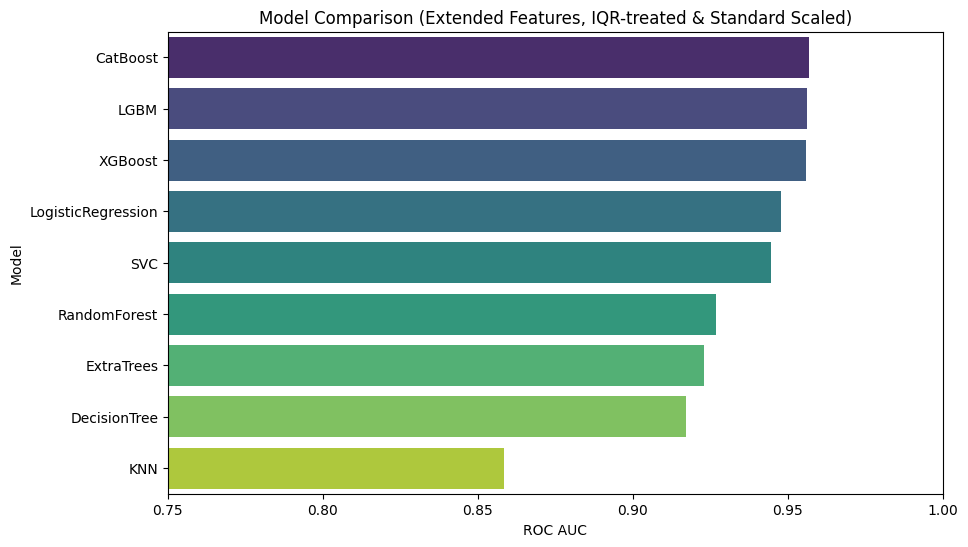

In [10]:
# Performance Comparison
results_df = pd.DataFrame(list(model_results.items()), columns=['Model', 'AUC']).sort_values(by='AUC', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='AUC', y='Model', data=results_df, palette='viridis')
plt.title('Model Comparison (Extended Features, IQR-treated & Standard Scaled)')
plt.xlabel('ROC AUC')
plt.xlim(0.75, 1.0)
plt.show()

### Final Submission Selection
We map each model to its submission file name, identify the best model by ROC AUC, and copy its submission as `submission.csv`. All individual submission files are also listed.

In [11]:
# Final Submission Selection
import shutil

submission_files = {
    'LogisticRegression': "LogisticRegression_submission.csv",
    'DecisionTree': "DecisionTree_submission.csv",
    'ExtraTrees': "ExtraTrees_submission.csv",
    'RandomForest': "RandomForest_submission.csv",
    'XGBoost': "XGBoost_submission.csv",
    'CatBoost': "CatBoost_submission.csv",
    'LGBM': "LGBM_submission.csv",
    'KNN': "KNN_submission.csv",
    'SVC': "SVC_submission.csv",
    'NN': "NN_submission.csv"
}

best_model_name = max(model_results, key=model_results.get)
best_submission_file = submission_files.get(best_model_name)
if best_submission_file is None or not os.path.exists(best_submission_file):
    raise ValueError("Best model submission file not found.")
else:
    shutil.copy(best_submission_file, "submission.csv")
    logger.info(f"Best scoring model: {best_model_name}")
    logger.info(f"Copied {best_submission_file} as 'submission.csv'")

logger.info("\nAll individual model submissions:")
for model, filename in submission_files.items():
    logger.info(f"- {filename}")

### Conclusion
**Conclusion:**

1. **Unified Feature Engineering:**  
   We built a unified transformer that creates date‑based, periodic, interaction/ratio, lag (for training), polynomial, and rolling‑window features—all in one pass.  
2. **Outlier Treatment:**  
   A custom transformer applies IQR‑based clipping with a tunable multiplier.  
3. **Enhanced Pipeline:**  
   Our pipeline includes imputation, scaling, feature selection, and model training with broad hyperparameter tuning via RandomizedSearchCV (and Keras Tuner for the NN).  
4. **Hyperparameter Tuning and Model Selection:**  
   Multiple classical models and a neural network are tuned with cross‑validation. The selected features from the feature selection step are logged for each model.  
5. **Reproducibility and Ensembling:**  
   Consistent random seeds and logging allow for reproducible results. Final submissions are saved individually, and the best model’s submission is copied as submission.csv.

Happy modeling and best of luck in the competition!

In [12]:
results_df

,Model,AUC
5,CatBoost,0.956740
6,LGBM,0.956066
4,XGBoost,0.955836
0,LogisticRegression,0.947761
8,SVC,0.944400
3,RandomForest,0.926801
2,ExtraTrees,0.922789
1,DecisionTree,0.917076
7,KNN,0.858575
